### task 4.1. Реализовать BiRNN & LSTM по предсказанию цены Bitcoin (или можете взять любой другой финансовый инструмент)

### Importing Libraries

In [1]:
#!pip install plotly.express
#!pip install tensorflow 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

2024-09-29 23:34:53.952215: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 23:34:53.962333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 23:34:54.031893: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 23:34:54.101228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 23:34:54.150644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Reading bitcoin dataset from Kaggle

In [2]:
df = pd.read_csv('bitcoin_2017_to_2023.csv')

In [3]:
df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3126000 entries, 0 to 3125999
Data columns (total 10 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   timestamp                     object 
 1   open                          float64
 2   high                          float64
 3   low                           float64
 4   close                         float64
 5   volume                        float64
 6   quote_asset_volume            float64
 7   number_of_trades              int64  
 8   taker_buy_base_asset_volume   float64
 9   taker_buy_quote_asset_volume  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 238.5+ MB


In [5]:
df.describe()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,3.126000e+06,3.126000e+06,3.126000e+06,3.126000e+06,3.126000e+06,3.126000e+06,3.126000e+06,3.126000e+06,3.126000e+06
mean,2.008947e+04,2.010217e+04,2.007666e+04,2.008946e+04,5.290800e+01,1.155882e+06,1.018583e+03,2.632231e+01,5.727211e+05
std,1.605896e+04,1.606926e+04,1.604871e+04,1.605896e+04,9.774388e+01,2.335868e+06,1.817813e+03,4.972880e+01,1.193135e+06
min,2.830000e+03,2.830000e+03,2.817000e+03,2.817000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.624747e+03,7.629600e+03,7.620000e+03,7.624798e+03,1.120167e+01,1.122335e+05,1.500000e+02,5.100715e+00,5.125057e+04
50%,1.169999e+04,1.170681e+04,1.169249e+04,1.170000e+04,2.387539e+01,3.706467e+05,4.130000e+02,1.148990e+01,1.753695e+05
75%,2.989957e+04,2.990724e+04,2.989051e+04,2.989957e+04,5.393630e+01,1.276762e+06,1.026000e+03,2.693009e+01,6.210250e+05
max,6.900000e+04,6.900000e+04,6.878670e+04,6.900000e+04,5.877775e+03,1.459557e+08,1.073150e+05,3.537453e+03,8.947551e+07


### Data preparation

##### Feature subset selection

In [6]:
df.drop(['volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'], axis=1, inplace=True)

##### Transforming data

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by='timestamp', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.head()

,timestamp,open,high,low,close
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48


##### Checking duplicates

In [9]:
df.duplicated().sum()

2072

In [10]:
df = df[df.duplicated() == False]

##### Checking missing values

In [11]:
df.isnull().sum().sum()

0

##### Let's take the average daily open price to reduce the size of the dataframe

In [12]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date

In [13]:
df = df.groupby('date')[['open', 'high', 'low', 'close']].mean()

In [23]:
df = df.reset_index()

In [40]:
df['date'] = pd.to_datetime(df['date'], format= '%d/%m/%Y')

### Visualising Bitcoin price history data

In [2]:
#!pip install --upgrade nbformat

In [44]:
fig = px.line(y=df['open'], x=df['date'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Open Price",
                  title={'text': "Bitcoin Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

### Splitting Data to Training & Test Sets

In [46]:
test_size = df[df['date'].dt.year==2023].shape[0]
test_size

213

__Bitcoin Price Training and Test Sets Plot__

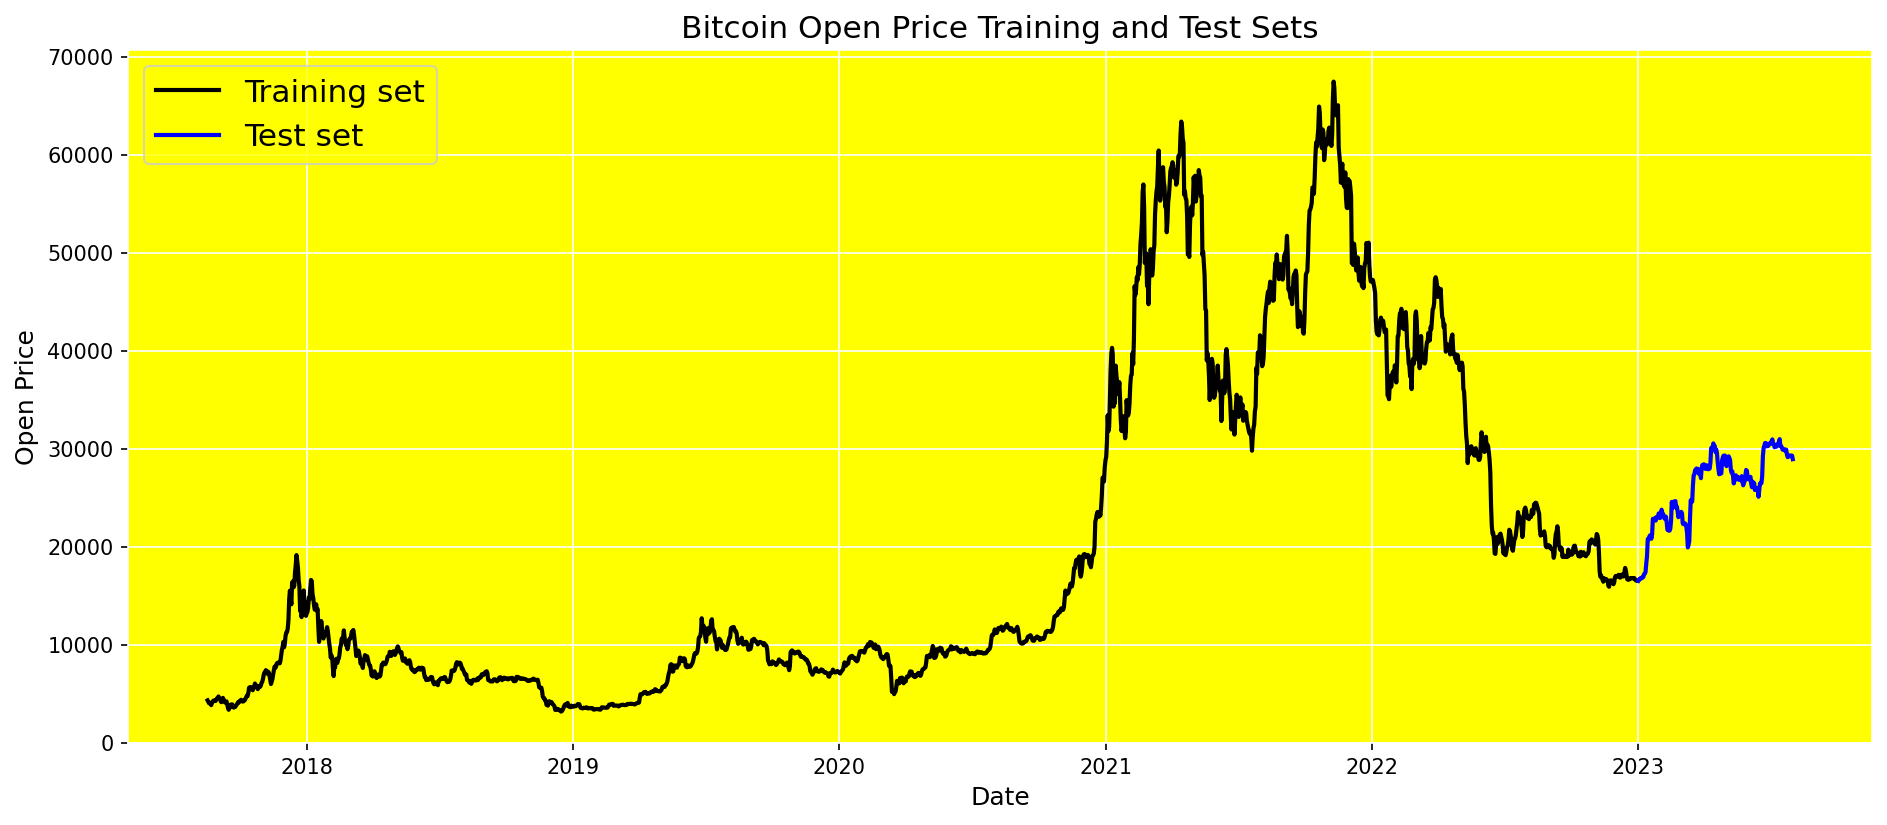

In [47]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date[:-test_size], df.open[:-test_size], color='black', lw=2)
plt.plot(df.date[-test_size:], df.open[-test_size:], color='blue', lw=2)
plt.title('Bitcoin Open Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Open Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

### Data Scaling

In [48]:
scaler = MinMaxScaler()
scaler.fit(df.open.values.reshape(-1,1))

MinMaxScaler()

### Restructure Data & Create Sliding Window

In [49]:
window_size = 30

__Training Set:__

In [50]:
train_data = df.open[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [51]:
train_data

array([[0.01780295],
       [0.01580831],
       [0.01332193],
       ...,
       [0.20810344],
       [0.20743226],
       [0.20774335]])

In [52]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [53]:
test_data = df.open[-test_size-30:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [54]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-30:i, 0])
    y_test.append(test_data[i, 0])

### Converting Data to Numpy Arrays

In [55]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [56]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [57]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (1933, 30, 1)
y_train Shape:  (1933, 1)
X_test Shape:   (213, 30, 1)
y_test Shape:   (213, 1)


### Creating an LSTM Network 

__Model Definition:__

In [58]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()
    
    return model

__Model Training:__

In [60]:
model = define_model()
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0883 - val_loss: 0.0301
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 4.2696e-04
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032 - val_loss: 8.5943e-04
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0033 - val_loss: 4.9354e-04
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 8.6008e-04
Epoch 10/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 9.2359e-04
Epoch 11/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 8.1001e-04
Epoch 12/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 

### Model Evaluation

In [61]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1127e-04 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [62]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [63]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0004438119940459728
Test MAPE: 0.04376168711920382
Test Accuracy: 0.9562383128807962


### Visualizing Results

__Returning the actual and predicted Price values to their primary scale:__

In [64]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the actual prices:__

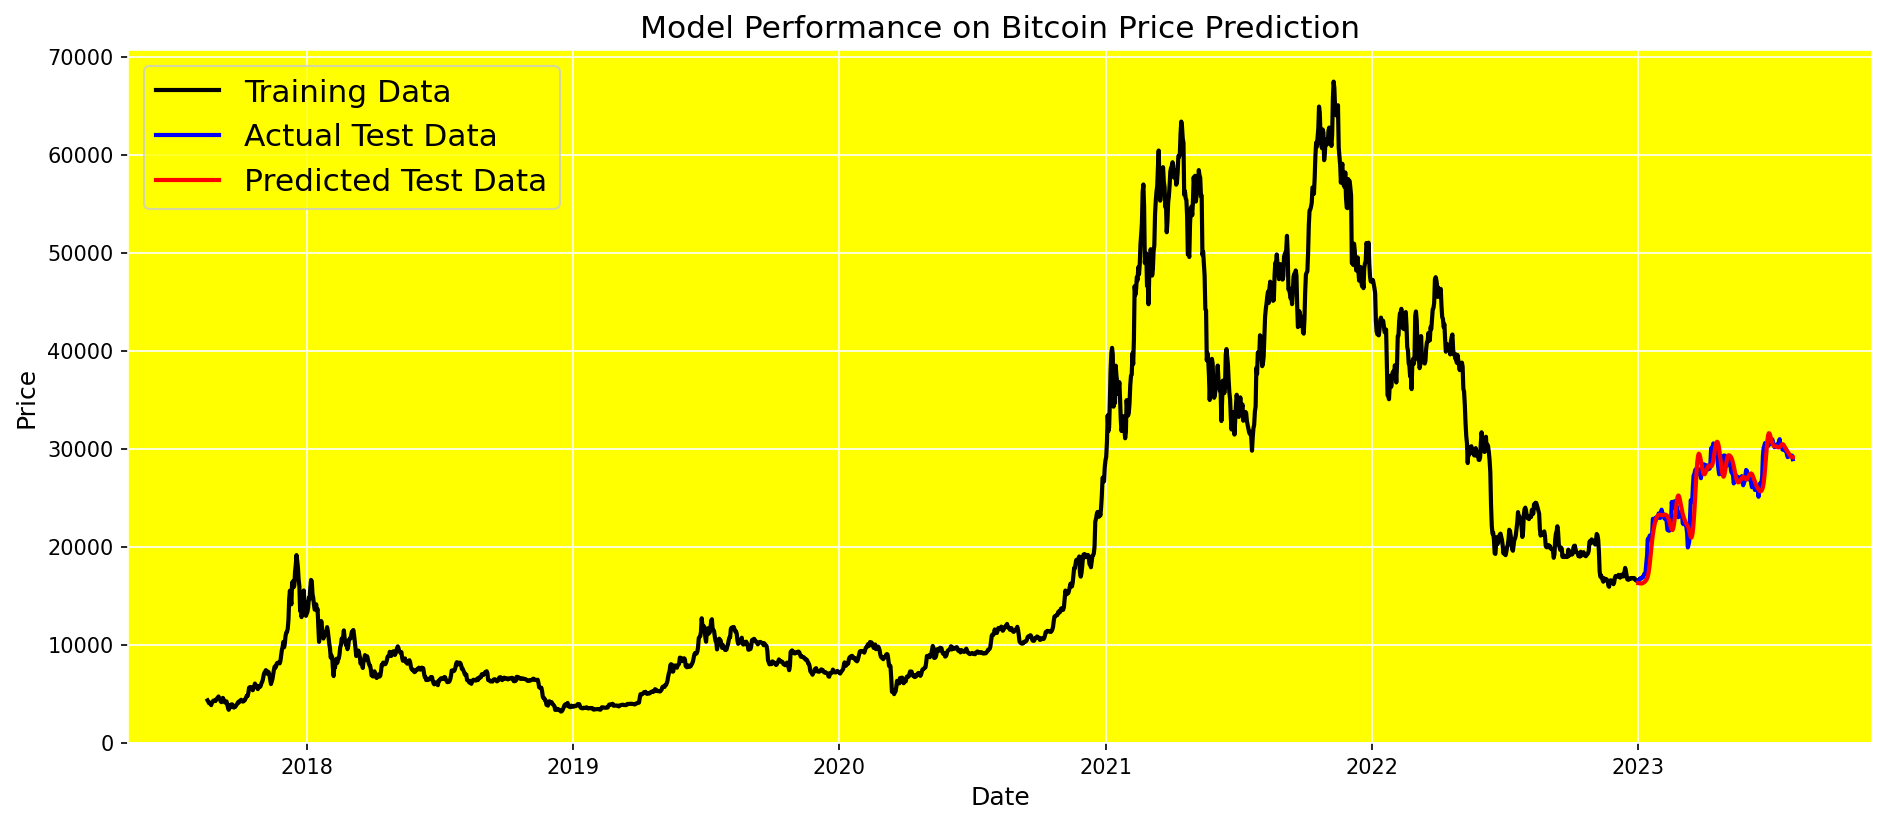

In [65]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Bitcoin Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()